# Section 2: Location & Trend Analysis

## Overview
In this section, we analyze the spatial/temporal distribution of mortality data in San Francisco. Our primary objectives are to identify high-risk geographic clusters ("hotspots") and evaluate time-based trends using statistical regression.

### Key Objectives:
* **Data Preparation:** Clean raw data using Pandas (handling missing values, datetime conversion).
* **Temporal Analysis:** Visualize time trends using line plots and simple regression.
* **Categorical Analysis:** Compare neighborhood mortality rates using bar charts.
* **Spatial Analysis:** Generate heatmaps to identify blocks/areas with the highest death density by month.

## Data Loading & Static Charts

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

df = pd.read_csv("../data/cleaned_fatality_data.csv")

# prepare dates
df['date'] = pd.to_datetime(df['collision_date'])
df['month_year'] = df['date'].dt.to_period('M')

neighborhood_counts = df['analysis_neighborhood'].value_counts().reset_index()
neighborhood_counts.columns = ['Neighborhood', 'Deaths']

neighborhood_counts

,Neighborhood,Deaths
0,Mission,38
1,Bayview Hunters Point,30
2,Tenderloin,28
3,South of Market,27
4,Financial District/South Beach,15
5,Sunset/Parkside,14
6,Marina,13
7,West of Twin Peaks,13
8,Hayes Valley,12
9,Portola,11


## 1. Which Areas Have the Most Deaths?

/tmp/ipykernel_211/2958859559.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neighborhood_counts.head(10), x='Deaths', y='Neighborhood', palette='Reds_r')


Saved: ../figures/neighborhood_deaths.png


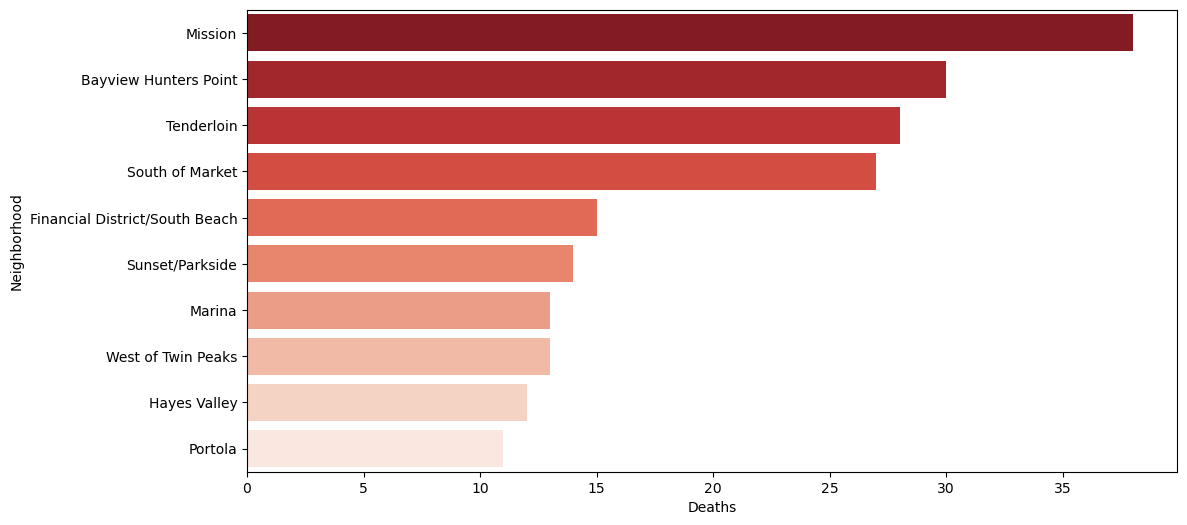

In [52]:
#create visualization
block_counts = df['location'].value_counts().head(10)
block_counts

plt.figure(figsize=(12, 6))
sns.barplot(data=neighborhood_counts.head(10), x='Deaths', y='Neighborhood', palette='Reds_r')

plt.savefig('../figures/neighborhood_deaths.png')
print("Saved: ../figures/neighborhood_deaths.png")
plt.show()

In [17]:
print("Most Dangerous Intersections:\n", block_counts)

Most Dangerous Intersections:
 location
Ulloa St and Lenox Way                       4
Brannan Street and 9th Street                3
Dakota Street and 25th Street                2
Mansell St and San Bruno Ave                 2
Third Street and Paul Avenue                 2
Mission Street and 2nd Street                2
3rd St at Mission St                         2
Grafton Ave and Jules Ave                    2
Larkin St and Eddy St                        2
Golden Gate Avenue and Leavenworth Street    1
Name: count, dtype: int64


## 2. Time Trend Analysis

Saved: ../figures/fatality_trends.png


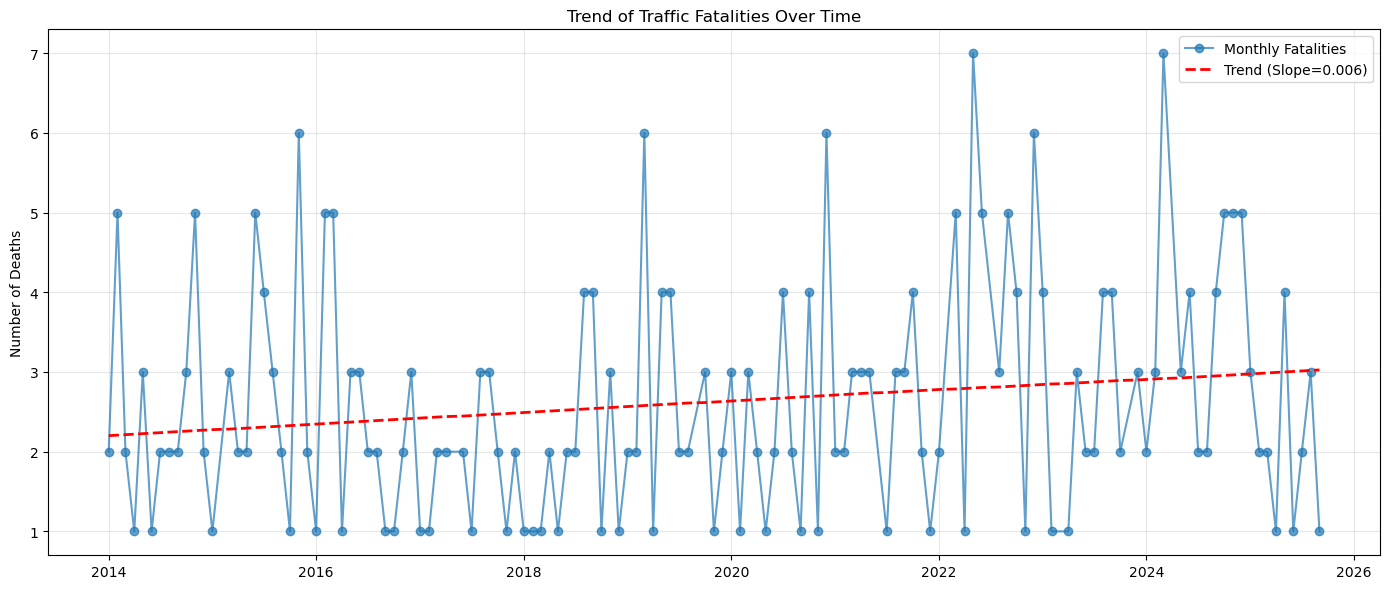

Regression Slope: 0.0063


In [51]:
monthly_trend = df.groupby('month_year').size()
monthly_trend.index = monthly_trend.index.to_timestamp()

plt.figure(figsize = (14, 6))
plt.plot(monthly_trend.index, monthly_trend.values, marker='o', linestyle='-', alpha=0.7, label='Monthly Fatalities')

#regression
x_nums = np.arange(len(monthly_trend))
slope, intercept, r_value, p_value, std_err = stats.linregress(x_nums, monthly_trend.values)
plt.plot(monthly_trend.index, intercept + slope * x_nums, 'r--', linewidth=2, label=f'Trend (Slope={slope:.3f})')

plt.title('Trend of Traffic Fatalities Over Time')
plt.ylabel('Number of Deaths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# SAVE TO FIGURES FOLDER
plt.savefig('../figures/fatality_trends.png')
print("Saved: ../figures/fatality_trends.png")
plt.show()

print(f"Regression Slope: {slope:.4f}")

## 3. Location Heatmaps of San Francisco (By Month)

In [38]:
import folium
from folium.plugins import HeatMap

In [53]:
df = pd.read_csv("../data/cleaned_fatality_data.csv")
df = df.dropna(subset=['latitude', 'longitude']).copy()

# 3. create Age Groups (Pre-calculation)
age_bins = [0, 19, 35, 50, 65, 200]
age_labels = ["0–18", "19–34", "35–49", "50–64", "65+"]
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

def add_heat_layer(m, data, name, radius=15, blur=20):
    if len(data) == 0:
        return
    # Default: Only "All Fatalities" is checked/visible
    fg = folium.FeatureGroup(name=name, show=(name=="All Fatalities"))
    HeatMap(
        data[['latitude', 'longitude']].values.tolist(),
        radius=radius,
        blur=blur,
        min_opacity=0.3
    ).add_to(fg)
    fg.add_to(m)

# 1. all fatalities
add_heat_layer(m, df, "All Fatalities")

# 2. per month
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
for month in months_order:
    sub = df[df['month_name'] == month]
    if len(sub) > 0:
        add_heat_layer(m, sub, f"Month: {month}")

# 3. per time_of_day
time_order = ["Night (00–05)", "Morning (06–11)", "Afternoon (12–17)", "Evening (18–23)"]
for t in time_order:
    sub = df[df["time_of_day"] == t]
    if len(sub) > 0:
        add_heat_layer(m, sub, t)

# 4. per year
years = sorted(df["year"].dropna().unique())
for y in years:
    sub = df[df["year"] == y]
    add_heat_layer(m, sub, f"Year: {int(y)}")

# 5. age 
for ag in age_labels:
    sub = df[df["age_group"] == ag]
    if len(sub) > 0:
        add_heat_layer(m, sub, f"Age: {ag}")

folium.LayerControl(collapsed=False).add_to(m)
m.save("../figures/Section2_Fatality_Heatmap.html")
print("Saved: ../figures/Section2_Fatality_Heatmap.html")
m

Saved: ../figures/Section2_Fatality_Heatmap.html


#### Check Environment

In [2]:
import sys
sys.executable


'/srv/conda/envs/notebook/bin/python'